In [214]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,Conv1D,MaxPooling1D, Bidirectional, BatchNormalization, LayerNormalization
from sklearn import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from tensorflow.keras.models import load_model

In [202]:
data=pd.read_csv("saved.csv")
data.drop(data.columns[0],axis=1,inplace=True)
train = pd.DataFrame(data[0:int(len(data)*0.90)])
train_y = train["targetClass"]
test = pd.DataFrame(data[int(len(data)*0.90): int(len(data))])
test_y = test["targetClass"]
train.drop(["target","targetClass"],axis=1, inplace=True)
test.drop(["target","targetClass"],axis=1, inplace=True)
columns=train.columns
train

,Volume,SMA14,WMA14,Momentum,ADO,STCK,STCD,LWR,RSI,CCI,Signal
0,106873020,13.417257,13.369057,-1.214464,0.330690,24.906533,1206.493417,75.093467,25.302781,-5.065139,-0.156614
1,96303600,13.392929,13.369879,-0.340591,0.372159,50.838694,1455.296008,49.161306,39.877998,37.340864,-0.152446
2,91096812,13.380631,13.363001,-0.172173,0.606017,39.277716,1696.364794,60.722284,44.314011,-0.683571,-0.147653
3,146029824,13.378629,13.385056,-0.028028,0.287895,74.791554,2171.249575,25.208446,49.154844,123.852263,-0.141348
4,81106812,13.371675,13.397068,-0.097347,0.896373,64.180918,2560.860845,35.819082,47.182390,106.170008,-0.134409
...,...,...,...,...,...,...,...,...,...,...,...
2915,15314000,142.807036,143.623047,7.861007,0.679174,75.345343,8576.897363,24.654657,77.155645,-8.659302,0.885718
2916,36840000,143.053215,143.365577,3.446503,0.965331,37.801527,8264.771668,62.198473,61.197605,-93.293175,0.850615
2917,22094000,143.216858,143.269482,2.291000,0.363232,33.708123,7881.075552,66.291877,58.047654,-103.308189,0.809565
2918,19674000,143.308500,143.179834,1.282990,0.507445,32.750017,7475.385270,67.249983,54.850275,-72.713723,0.765768


In [203]:
scaler=preprocessing.MinMaxScaler()
train=scaler.fit_transform(train)
test=scaler.transform(test)
train=pd.DataFrame(train,columns=columns)
test=pd.DataFrame(test,columns=columns)

In [204]:
step_size = 10
num_samples = len(train) - step_size  
train = np.array([train[i : i + step_size] for i in range(num_samples)])  
train_y = np.array([train_y[i + step_size] for i in range(num_samples)])  
print("Shape of reshaped_train:",train.shape)  
print("Shape of reshaped_train_y:", train_y.shape)  

Shape of reshaped_train: (2910, 10, 11)
Shape of reshaped_train_y: (2910,)


In [205]:
num_test_samples = len(test) - step_size  
test = np.array(test)
test_y = np.array(test_y)
test = np.array([test[i : i + step_size] for i in range(num_test_samples)])
test_y = np.array([test_y[i + step_size] for i in range(num_test_samples)])

In [229]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(10, 11)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(LSTM(units=64, activation="relu", return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.25))
model.add(LayerNormalization())
model.add(LSTM(units=32, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dense(1,activation="sigmoid"))  

In [230]:
checkpoint = ModelCheckpoint(
    filepath="cnn_weights_best.h5",  
    monitor="val_accuracy",        
    save_best_only=True,
    save_weights_only=True,           
    mode="max",                 
    verbose=1
)

In [234]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.00045), loss="binary_crossentropy", metrics=["accuracy"])
history=model.fit(train, train_y, epochs=100, validation_data=(test,test_y), batch_size=16,callbacks=[checkpoint])

Epoch 1/100
181/182 [============================>.] - ETA: 0s - loss: 0.4764 - accuracy: 0.7901
Epoch 1: val_accuracy did not improve from 0.54603
182/182 [==============================] - 6s 11ms/step - loss: 0.4764 - accuracy: 0.7900 - val_loss: 1.1482 - val_accuracy: 0.5016
Epoch 2/100
178/182 [============================>.] - ETA: 0s - loss: 0.4802 - accuracy: 0.7879
Epoch 2: val_accuracy did not improve from 0.54603
182/182 [==============================] - 1s 7ms/step - loss: 0.4790 - accuracy: 0.7890 - val_loss: 1.2371 - val_accuracy: 0.5175
Epoch 3/100
175/182 [===========================>..] - ETA: 0s - loss: 0.4955 - accuracy: 0.7768
Epoch 3: val_accuracy did not improve from 0.54603
182/182 [==============================] - 1s 7ms/step - loss: 0.4947 - accuracy: 0.7770 - val_loss: 1.2489 - val_accuracy: 0.5175
Epoch 4/100
180/182 [============================>.] - ETA: 0s - loss: 0.4724 - accuracy: 0.8083
Epoch 4: val_accuracy did not improve from 0.54603
182/182 [=====

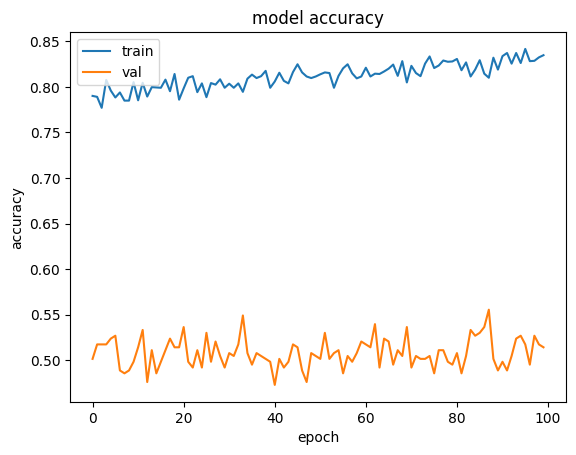

In [235]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

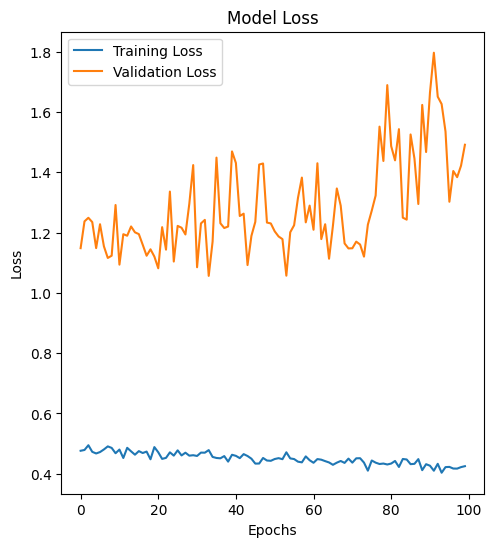

In [236]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [237]:
data=pd.read_csv("Google_Stock_Test (2023).csv")

In [238]:
def calculate_rsi(data, period=14):
    delta = data.diff()
    
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

data["SMA14"]=data["Close"].rolling(window=14).mean()
data["WMA14"] = data["Close"].rolling(window=14).apply(lambda x: np.sum(range(1,15)*x) / 105, raw=False)
data["Momentum"]=data["Close"].diff(periods=14)
data["ADO"]=(data["High"]-data["Close"])/(data["High"]-data["Low"])
data["M"]=(data["High"]+data["Low"]+data["Close"])/3
data["SM"]=data["M"].rolling(window=10).mean()
data["LL14"]=data["Low"].rolling(window=14).min()
data["HH14"]=data["High"].rolling(window=14).max()
data["STCK"]=((data["Close"]-data["LL14"])/(data["HH14"]-data["LL14"]))*100
data["STCD"]=data["STCK"].rolling(window=14).mean()
data["STCD"]=100*data["STCD"]
data["LWR"]=((data["HH14"]-data["Close"])/(data["HH14"]-data["LL14"]))*100
data["RSI"]=calculate_rsi(data['Close'], period=14)
data["D"] = data["M"].rolling(window=14).apply(lambda x: abs(x - x.mean()).mean(), raw=False)
data["CCI"]=(data["M"]-data["SM"])/(0.015*data["D"])
data["EMA_Fast"] = data["Close"].ewm(span=12, adjust=False).mean()
data["EMA_Slow"] = data["Close"].ewm(span=16, adjust=False).mean()
data["MACD"] = data["EMA_Fast"] - data["EMA_Slow"]
data["Signal"] = data["MACD"].ewm(span=14, adjust=False).mean()

data["target"]=data["Adj Close"]-data["Open"]
data["target"]=data["target"].shift(-1)
data["targetClass"]=data["target"].apply(lambda x: 1 if x > 0 else 0)

data.dropna(inplace=True)
data.drop(["D","SM","M","HH14","LL14","MACD","EMA_Fast","EMA_Slow","Open","High","Low","Close","Adj Close","Date"], axis=1,inplace=True)
test=data
test_y = test["targetClass"]
data.drop(["target","targetClass"],axis=1, inplace=True)
columns=test.columns
test=scaler.transform(test)
test=pd.DataFrame(test,columns=columns)
num_test_samples = len(test) - step_size  
test = np.array(test)
test_y = np.array(test_y)
test = np.array([test[i : i + step_size] for i in range(num_test_samples)])
test_y = np.array([test_y[i + step_size] for i in range(num_test_samples)])

In [239]:
model.load_weights("cnn_weights_best.h5")
prediction=model.predict(test)

4/4 [==============================] - 0s 6ms/step


In [240]:
binary_predictions = (prediction >= 0.5).astype(int)
accuracy = metrics.accuracy_score(test_y, binary_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5566037735849056
